In [281]:
%matplotlib inline

import sys
import os

# Add parent directory (where pygestalt lives) to sys.path
sys.path.append(os.path.abspath(".."))

from pathlib import Path

import ipywidgets as widgets

from IPython.display import display

import math
import numpy as np
import scipy
from scipy.spatial import cKDTree
from skimage.filters import gabor
from skimage import exposure
import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib.pyplot import *

import pygestalt as gs
from pygestalt import sampler

import skimage as ski

In [282]:
outdir = Path(os.getcwd()) / 'outputs'
os.makedirs(outdir, exist_ok=True)

In [283]:
#Ps = np.random.uniform(size=(4,2))
#Ps = np.vstack([[0.2,0], Ps, [0.8,1]])

Ps = np.array([[0.,0.], [0.1,0.9], [0.9,0.1], [1.,1.]])
#Ps = np.array([[0.,0.], [1.,1.]])
bx, by = gs.sampler.bezier_curve_position(np.linspace(0,1,100),Ps).T


In [284]:
radius = 0.02
thresh = 1e-3

%time C, H = sampler.draw_positions(radius, sampler.bezier_curve(Ps), thresh=thresh)
%time D, _ = sampler.draw_positions(radius, sampler.box(), exclusions=C, thresh=thresh)

CPU times: user 3.43 s, sys: 41.8 ms, total: 3.47 s
Wall time: 3.69 s
CPU times: user 17.8 s, sys: 191 ms, total: 18 s
Wall time: 18.2 s


In [285]:
N = 512
If, Tf = gs.patch.generate_image(C, H, N=N, pfunc=pfunc)
Ig, Tg = gs.patch.generate_image(D, N=N, pfunc=pfunc)

I = If + Ig

Im = I.copy()
# Im = np.fliplr(np.rot90(Im,-1))

In [286]:
# Define the patch function

l=0.025
w=0.005
pfunc = lambda z,h: gs.patch.segment(z, h, l, w)

In [287]:
def _sigma_prefactor(bandwidth):
    b = bandwidth
    # See http://www.cs.rug.nl/~imaging/simplecell.html
    return 1.0 / np.pi * math.sqrt(math.log(2) / 2.0) * (2.0**b + 1) / (2.0**b - 1)

def gabor_kernel(
    frequency,
    theta=0,
    bandwidth=1,
    sigma_x=None,
    sigma_y=None,
    n_stds=3,
    offset=0,
    dtype=np.complex128,
):
    """Return complex 2D Gabor filter kernel.

    Gabor kernel is a Gaussian kernel modulated by a complex harmonic function.
    Harmonic function consists of an imaginary sine function and a real
    cosine function. Spatial frequency is inversely proportional to the
    wavelength of the harmonic and to the standard deviation of a Gaussian
    kernel. The bandwidth is also inversely proportional to the standard
    deviation.

    Parameters
    ----------
    frequency : float
        Spatial frequency of the harmonic function. Specified in pixels.
    theta : float, optional
        Orientation in radians. If 0, the harmonic is in the x-direction.
    bandwidth : float, optional
        The bandwidth captured by the filter. For fixed bandwidth, ``sigma_x``
        and ``sigma_y`` will decrease with increasing frequency. This value is
        ignored if ``sigma_x`` and ``sigma_y`` are set by the user.
    sigma_x, sigma_y : float, optional
        Standard deviation in x- and y-directions. These directions apply to
        the kernel *before* rotation. If `theta = pi/2`, then the kernel is
        rotated 90 degrees so that ``sigma_x`` controls the *vertical*
        direction.
    n_stds : scalar, optional
        The linear size of the kernel is n_stds (3 by default) standard
        deviations
    offset : float, optional
        Phase offset of harmonic function in radians.
    dtype : {np.complex64, np.complex128}
        Specifies if the filter is single or double precision complex.

    Returns
    -------
    g : complex array
        Complex filter kernel.

    References
    ----------
    .. [1] https://en.wikipedia.org/wiki/Gabor_filter
    .. [2] https://web.archive.org/web/20180127125930/http://mplab.ucsd.edu/tutorials/gabor.pdf

    Examples
    --------
    >>> from skimage.filters import gabor_kernel
    >>> from matplotlib import pyplot as plt  # doctest: +SKIP

    >>> gk = gabor_kernel(frequency=0.2)
    >>> fig, ax = plt.subplots()  # doctest: +SKIP
    >>> ax.imshow(gk.real)        # doctest: +SKIP
    >>> plt.show()                # doctest: +SKIP

    >>> # more ripples (equivalent to increasing the size of the
    >>> # Gaussian spread)
    >>> gk = gabor_kernel(frequency=0.2, bandwidth=0.1)
    >>> fig, ax = plt.suplots()  # doctest: +SKIP
    >>> ax.imshow(gk.real)       # doctest: +SKIP
    >>> plt.show()               # doctest: +SKIP
    """
    if sigma_x is None:
        sigma_x = _sigma_prefactor(bandwidth) / frequency
    if sigma_y is None:
        sigma_y = _sigma_prefactor(bandwidth) / frequency

    if np.dtype(dtype).kind != 'c':
        raise ValueError("dtype must be complex")

    ct = math.cos(theta)
    st = math.sin(theta)
    x0 = math.ceil(max(abs(n_stds * sigma_x * ct), abs(n_stds * sigma_y * st), 1))
    y0 = math.ceil(max(abs(n_stds * sigma_y * ct), abs(n_stds * sigma_x * st), 1))
    y, x = np.meshgrid(
        np.arange(-y0, y0 + 1), np.arange(-x0, x0 + 1), indexing='ij', sparse=True
    )
    rotx = x * ct + y * st
    roty = -x * st + y * ct

    g = np.empty(roty.shape, dtype=dtype)
    np.exp(
        -0.5 * (rotx**2 / sigma_x**2 + roty**2 / sigma_y**2)
        + 1j * (2 * np.pi * frequency * rotx + offset),
        out=g,
    )
    g *= 1 / (2 * np.pi * sigma_x * sigma_y)

    return g


frequency = 0.1
theta = 0 #np.pi/4 # 90 degrees
bandwidth=1
sigma_x= 1.0 #None,
sigma_y= 3.0 #None,
n_stds=3.0
offset=0
mode='reflect'
cval=0
kernel_dtype = np.complex128

g = gabor_kernel(
    frequency,
    theta,
    bandwidth,
    sigma_x,
    sigma_y,
    n_stds,
    offset,
    dtype=kernel_dtype,
)

In [288]:
def show_gabor_kernel(g, cmap='gray'):
    """
    Display a complex Gabor kernel with real, imaginary, and magnitude.

    Parameters
    ----------
    g : np.ndarray
        Complex Gabor kernel.
    cmap : str
        Colormap for visualization.
    """
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    axes[0].imshow(g.real, cmap=cmap, origin='lower')
    axes[0].set_title("Real Part")
    axes[0].axis('off')

    axes[1].imshow(g.imag, cmap=cmap, origin='lower')
    axes[1].set_title("Imaginary Part")
    axes[1].axis('off')

    axes[2].imshow(np.abs(g), cmap=cmap, origin='lower')
    axes[2].set_title("Magnitude")
    axes[2].axis('off')

    plt.suptitle("Gabor Kernel Visualization", fontsize=16)
    plt.tight_layout()
    plt.show()

# Usage

def interactive_gabor(frequency=0.1, theta=0.0, sigma_x=1.0, sigma_y=3.0):
    g = gabor_kernel(frequency, theta, sigma_x=sigma_x, sigma_y=sigma_y)
    show_gabor_kernel(g)

# Create sliders
freq_slider = widgets.FloatSlider(value=0.1, min=0.01, max=0.5, step=0.01, description='Frequency')
theta_slider = widgets.FloatSlider(value=0.0, min=0, max=np.pi, step=0.1, description='Theta')
sigmax_slider = widgets.FloatSlider(value=1.0, min=0.5, max=5.0, step=0.1, description='Sigma X')
sigmay_slider = widgets.FloatSlider(value=3.0, min=0.5, max=5.0, step=0.1, description='Sigma Y')

widgets.interactive(interactive_gabor,
                    frequency=freq_slider,
                    theta=theta_slider,
                    sigma_x=sigmax_slider,
                    sigma_y=sigmay_slider)

    # Embed kernel into 512x512 image

interactive(children=(FloatSlider(value=0.1, description='Frequency', max=0.5, min=0.01, step=0.01), FloatSlid…

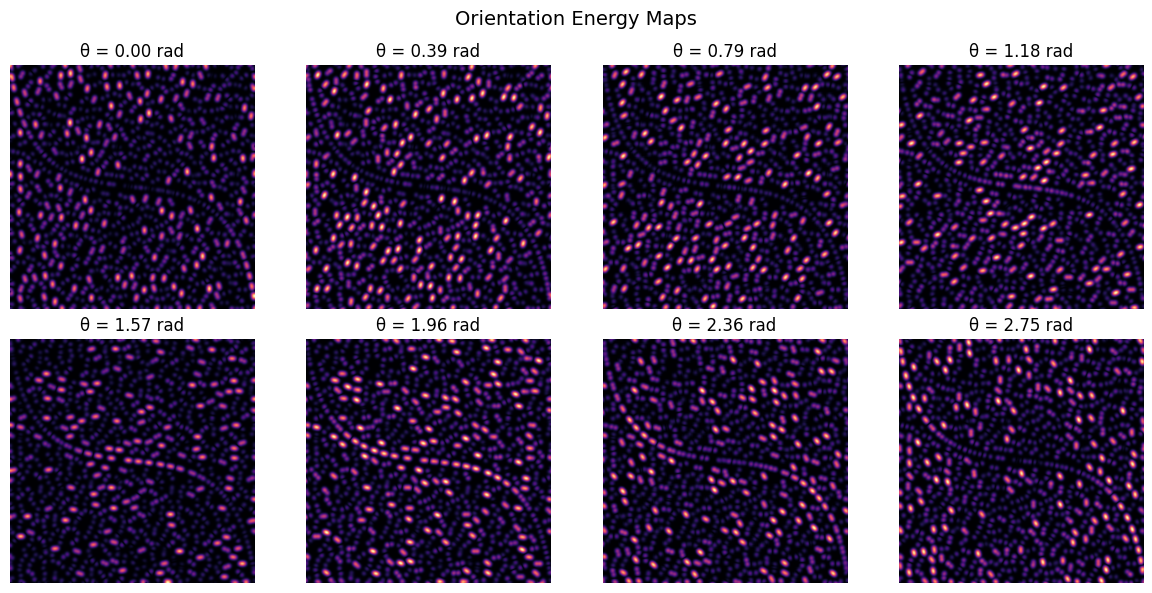

In [289]:
def compute_orientation_energy(If, orientations=None, frequency=0.1):
    """
    Compute orientation energy maps using Gabor filters.

    Parameters
    ----------
    If : np.ndarray
        2D grayscale image.
    orientations : list or np.ndarray
        List of orientations (radians) for Gabor filters.
    frequency : float
        Gabor filter frequency (default=0.1).

    Returns
    -------
    energy_maps : np.ndarray
        3D array of shape (H, W, num_orientations)
    orientations : np.ndarray
        Array of orientation angles used.
    """
    if orientations is None:
        orientations = np.linspace(0, np.pi, 8, endpoint=False)

    energy_maps = []
    for theta in orientations:
        real, imag = gabor(If, frequency=frequency, theta=theta)
        energy = np.sqrt(real**2 + imag**2)
        energy_maps.append(energy)

    return np.stack(energy_maps, axis=-1), orientations


def plot_orientation_energy_maps(energy_maps, orientations, cmap="magma"):
    """
    Plot orientation energy maps.

    Parameters
    ----------
    energy_maps : np.ndarray
        3D array of shape (H, W, num_orientations)
    orientations : np.ndarray
        Array of orientation angles (radians)
    cmap : str
        Colormap for visualization.
    """
    n = len(orientations)
    fig, axes = plt.subplots(2, n // 2, figsize=(12, 6))
    axes = axes.ravel()

    for i, ax in enumerate(axes):
        energy_img = exposure.rescale_intensity(energy_maps[..., i])
        ax.imshow(energy_img, cmap=cmap)
        ax.set_title(f"θ = {orientations[i]:.2f} rad")
        ax.axis("off")

    plt.suptitle("Orientation Energy Maps", fontsize=14)
    plt.tight_layout()
    plt.show()


# Normalize the image
If = Im.astype(float)
If = (If - If.min()) / (If.max() - If.min() + 1e-8)

energy_maps, orientations = compute_orientation_energy(If, frequency=0.15)
plot_orientation_energy_maps(energy_maps, orientations)

In [290]:
def closest_neighbours(points, tangents, i):
    """
    Find the nearest neighbouring points and their tangents for a given point.

    Parameters
    points : (n, d) ndarray
        Array of n points in d-dimensional space.
    tangents : (n, d) ndarray
        Array of tangent vectors corresponding to each point.
    i : int
        Index of the reference point.

    Returns
    spoint : (d,) ndarray 
        The reference point at index `i`.
    norm_stang : (d,) ndarray
        Normalized tangent vector of the reference point.
    closest_points : (k-1, d) ndarray
        Coordinates of the k-1 nearest neighbours (excluding the point itself).
    norm_tang : (k-1, d) ndarray
        Normalized tangent vectors of the neighbouring points.
    """
    tree = cKDTree(points)
    # Reference point and normalized tangent
    spoint = points[i]
    norm_stang = tangents[i] / np.linalg.norm(tangents[i])

    # Query 7 neighbors, drop the point itself
    dists, idxs = tree.query(spoint, k= 7)
    dists, idxs = dists[1:], idxs[1:]

    # Select neighbors
    closest_points = points[idxs]
    closest_tang   = tangents[idxs]

    # Normalize tangents as a 2D array
    norm_tang = closest_tang / np.linalg.norm(closest_tang, axis=1, keepdims=True) 

    # Dot products as a clean NumPy array
    #dots = norm_tang @ stang_norm

    return spoint, norm_stang, closest_points, norm_tang

In [291]:
def problem_score(points, ref_point, tangents, ref_tangent):
    # Vector between two sets of points
    shift = points - ref_point   # shape (n, d)

    # Normalize the vectors (row-wise)
    norms = np.linalg.norm(shift, axis=1, keepdims=True)  # shape (n, 1)
    norm_shift = shift / np.where(norms == 0, 1, norms)            # avoid division by zero

    # Compute dot products
    sdot = norm_shift @ ref_tangent                        # (n,) assuming stang is shape (d,)
    cdot = np.einsum("ij,ij->i", norm_shift, tangents)   # (n,) assuming tang is shape (n, d)

    # Similarity measure
    sim = np.abs(sdot * cdot)

    dist_cor = 10 / (9 + np.exp(5 * ((norms / 0.05)-1)))
    dist_cor = dist_cor.ravel()
    problem_score = sim * dist_cor
    
    result = [ref_point, ref_tangent, points, problem_score]
    result_lists = [arr.tolist() for arr in result]
    
    return result_lists

In [292]:
def select_points(points, tan, mask, target, max_points=2):
    """
    Select points and tangents based on a boolean mask.
    If more than max_points, keep only the closest to the target.
    """
    selected_points = points[mask]
    selected_tan = tan[mask]

    if selected_points.shape[0] > max_points:
        distances = np.linalg.norm(selected_points - target, axis=1)
        closest_indices = np.argsort(distances)[:max_points]
        selected_points = selected_points[closest_indices]
        selected_tan = selected_tan[closest_indices]
    
    return selected_points, selected_tan

def is_aligned(q):
    if len(q[0]) != 2:
        return False
    dot_product = abs(np.dot(q[1][0], q[1][1]))
    return dot_product > 0.85

In [293]:
def find_relevant_neighbours(target, target_tan, points, tan, threshold=0.8):
    """
    Find points and tangents whose direction from the target aligns with target_tan.
    If more than 2 points are relevant, keep only the 2 closest points to the target.

    Parameters:
    - target: array-like, shape (d,)
    - target_tan: array-like, shape (d,), assumed normalized
    - points: array-like, shape (n, d)
    - tan: array-like, shape (n, d)
    - threshold: float, minimum cosine similarity

    Returns:
    - points_relevant: array of points within threshold (up to 2 closest)
    - tan_relevant: array of corresponding tangents
    """
    # Vector from target to points
    diff = points - target  # shape (n, d)
    
    # Normalize vectors safely
    norms = np.linalg.norm(diff, axis=1, keepdims=True)
    diff_normalized = diff / np.where(norms == 0, 1, norms)
    
    # Cosine similarity with target tangent
    dots = np.abs(diff_normalized @ target_tan)

    # Usage
    points_aligned, tan_aligned = select_points(points, tan, dots >= threshold, target)
    points_unaligned, tan_unaligned = select_points(points, tan, dots >= 1 - threshold, target)

    aligned = np.array([points_aligned, tan_aligned])
    unaligned = np.array([points_unaligned, tan_unaligned])
    
    return aligned, unaligned

def alignment(aligned, unaligned):
    """Check if either 'aligned' or 'unaligned' pairs are sufficiently unaligned."""
    
    return is_aligned(aligned) or is_aligned(unaligned)

def points_transform(points, tangents, length): 

    norms = np.linalg.norm(tangents, axis=1, keepdims=True)
    tangents_normalized = tangents / np.where(norms == 0, 1, norms)
    add = ((length/2) * tangents_normalized)
    new_points = points + add
    return new_points

In [294]:
points = points_transform(D, Tg, l)       # coordinates (N, 2)
tangents = Tg      # tangent vectors (N, 2)

#points = np.array([[0.5, 0.5], [0.25, 0.25], [0.75, 0.25], [0.20, 0.5], [0.80, 0.5], [0.25, 0.75], [0.75, 0.75]])
#tangents = np.array([[2, 0], [(-1), (-1)], [(-1), 1], [(-1), 0], [1,1], [0,1], [1, 0]])

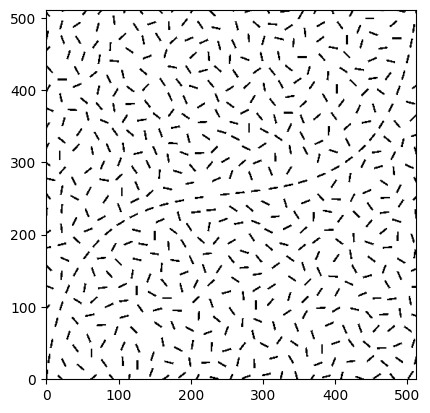

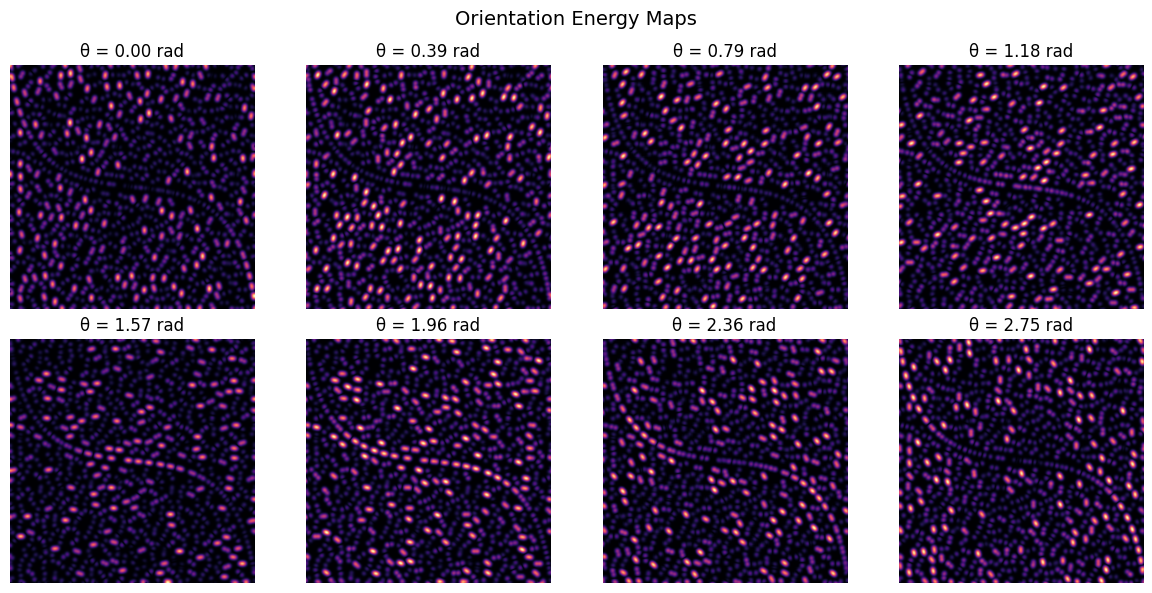

In [295]:
plt.imshow(Im, aspect='equal', origin='lower', cmap='binary')
# plt.set_cmap('binary')

# Normalize the image
If = Im.astype(float)
If = (If - If.min()) / (If.max() - If.min() + 1e-8)

energy_maps, orientations = compute_orientation_energy(If, frequency=0.15)
plot_orientation_energy_maps(energy_maps, orientations)

total = energy_maps.sum()

In [296]:
print("# streepjes met te hoge probleemscore.")
for a in range(50):
    ratings = []
    problems = []
    for b in range(len(points)):
        r, rt, p, pt = closest_neighbours(points, tangents, b)
        rating = problem_score(p, r, pt, rt)
        ratings.append(rating)
        for ps in rating[3]:
            if ps > 0.8:
                problems.append(b)
 
    for c in problems:
        tangents[c][0] = tangents[c][0] + np.random.uniform(-0.5, 0.5)
        tangents[c][1] = tangents[c][1] + np.random.uniform(-0.5, 0.5)
    print(len(problems))

print(len(points))

# streepjes met te hoge probleemscore.
267
231
199
164
136
139
119
113
96
89
82
67
53
54
52
51
49
38
36
36
37
35
32
40
32
34
29
31
30
30
24
22
18
20
16
14
12
10
8
8
8
8
12
10
10
10
10
8
10
10
511


In [297]:
print("# streepjes met teveel alignment.")
for i in range(10):
    zroblems = []
    for j in range(len(points)):
        t, tt, n, nt = closest_neighbours(points, tangents, j)
        par, per = find_relevant_neighbours(t, tt, n, nt)
        if alignment(par, per) == True:
            zroblems.append(j)

    for q in zroblems:
        tangents[q][0] = tangents[q][0] + np.random.uniform(-0.5, 0.5)
        tangents[q][1] = tangents[q][1] + np.random.uniform(-0.5, 0.5)
    print(len(zroblems))

print(len(points))

# streepjes met teveel alignment.
258
220
212
206
184
171
172
166
146
144
511


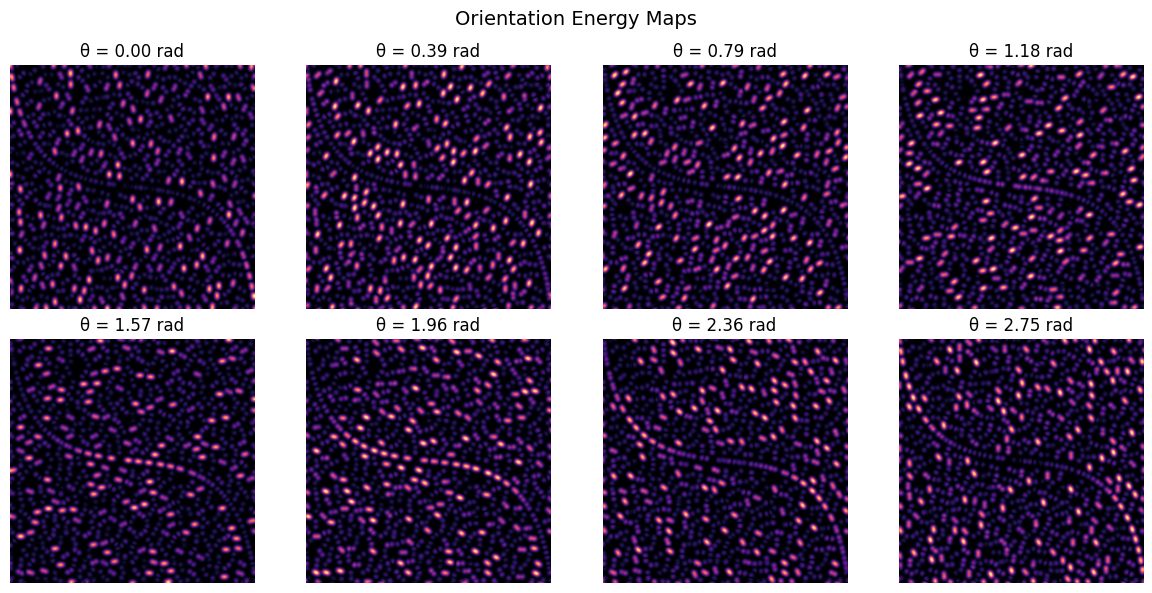

In [298]:
newIf, newTf = gs.patch.generate_image(C, H, N=N, pfunc=pfunc)
newIg, newTg = gs.patch.generate_image(D, tangents, N=N, pfunc=pfunc)

newI = newIf + newIg

newIm = newI.copy()

# Normalize the image
newIf = newIm.astype(float)
newIf = (newIf - newIf.min()) / (newIf.max() - newIf.min() + 1e-8)

newenergy_maps, neworientations = compute_orientation_energy(newIf, frequency=0.15)
plot_orientation_energy_maps(newenergy_maps, neworientations)

new_total = newenergy_maps.sum()

77.91817518312746


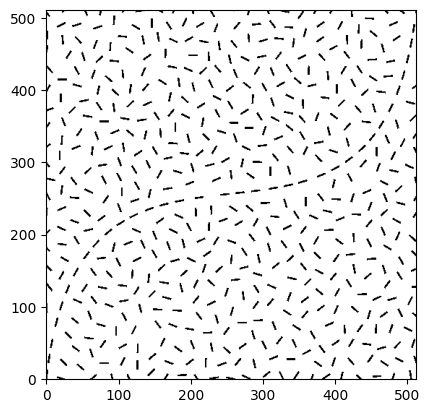

In [299]:
print(total - new_total)

plt.imshow(newIm, aspect='equal', origin='lower', cmap='binary')